In [1]:
import numpy as np
from matplotlib import pyplot as plt
import math
from skimage.measure import compare_ssim as ssim
from skimage.measure import compare_psnr as psnr
%matplotlib inline

In [2]:
def extract_data(path):
    data = np.load(path)
    reconstruct = data['reconstruct']
    past_gt = data['past_gt']
    future_gt = data['future_gt']
    future_pred = data['future_pred']
    loss = data['loss']
    if np.any(future_gt != None) and future_gt.shape[-1] == 1:
            future_gt = future_gt.squeeze()
            future_pred = future_pred.squeeze()
    if np.any(past_gt != None) and past_gt.shape[-1] == 1:
            past_gt = past_gt.squeeze()
            reconstruct = reconstruct.squeeze()
    return past_gt, reconstruct, future_gt,future_pred 

In [3]:

def compare_test(data, idx = -1, save_path='/home/cun/thesis/img_outputs/cmp.pdf'):
    # data [gt, pred1, pred2, ...]
    # use grayscale output rather than a (potentially misleading)
    # color heatmap
    plt.rcParams['image.cmap'] = 'gray'
    # don't interpolate: show square pixels
    plt.rcParams['image.interpolation'] = 'nearest'
    #plt.rcParams['image.aspect'] = 'auto'
    #print(plt.rcParams)
    rows = len(data)
    show_len = data[0].shape[0]
    fig = plt.figure(figsize=(16,8))
    #fig.subplots_adjust(wspace=0.01)
    fig.subplots_adjust(hspace=0.1)
    for s in range(rows):
        for i in range(show_len):
            
            fig.add_subplot(rows, show_len, s*show_len+i+1)            
            img = data[s][i, idx]
            v_max = np.amax(img)
            v_min = np.amin(img)
            img = (img - v_min) / (v_max - v_min)
            plt.imshow(img)            
            plt.axis('off')
    plt.savefig(save_path)

In [ ]:
def postprocess(x):
    """normalize data x within [0, 1]."""
    return (x + 1) / 2

In [4]:
convpath = '../latest_experiments/MovingMNIST/Predictor/StridedConvGRU0704-000108/test_outputs.npz'
trajpath = '../latest_experiments/MovingMNIST/Predictor/StridedConvGRU0704-133430/test_outputs.npz'
flowpath = '../latest_experiments/MovingMNIST/Predictor/StridedConvGRU0704-233855/test_outputs.npz'
fourierpath = '../latest_experiments/MovingMNIST/Predictor/StridedConvGRU0705-131207/test_outputs.npz'

_, _, future_gt_conv, future_pred_conv = extract_data(convpath)
_, _, future_gt_traj, future_pred_traj = extract_data(trajpath)
_, _, future_gt_flow, future_pred_flow = extract_data(flowpath)
_, _, future_gt_fourier, future_pred_fourier = extract_data(fourierpath)

In [5]:
print(future_pred_traj.shape)
print(np.amax(future_pred_traj))
print(np.amin(future_pred_traj))

(16, 2000, 64, 64)
0.9759488
5.1635907e-05


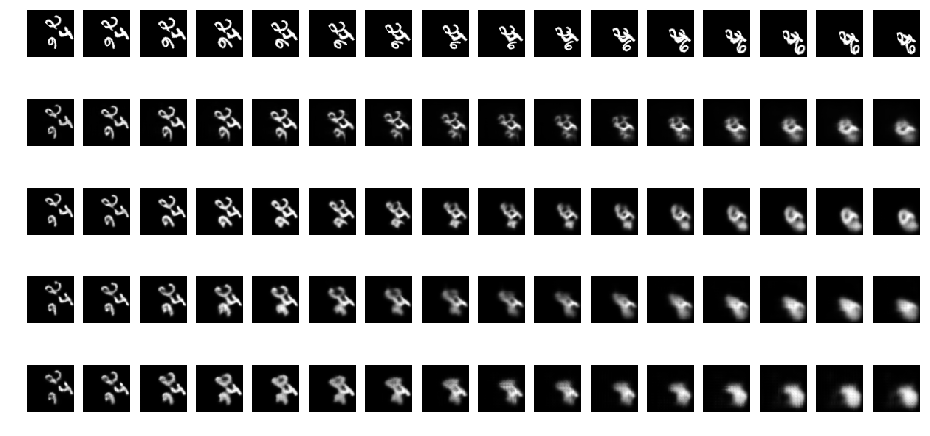

In [15]:
idx = -5
compare_test([future_gt_conv, future_pred_conv, future_pred_traj, future_pred_flow, future_pred_fourier], idx=idx)
#compare_test([gt_data, convpred], idx=-3)
#compare_test([gt_data, conv25pred, convcombpred], idx=-4)

In [8]:
def img_psnr(original_img, reconstructed_img, pixel_max=1):
    mse = np.mean( (original_img - reconstructed_img) ** 2 )
    if mse == 0:
        return 100
    return 20 * math.log10(pixel_max) - 10 * math.log10(mse)

In [9]:
print(img_psnr(future_gt_conv, future_pred_conv))
print(img_psnr(future_gt_traj, future_pred_traj))
print(img_psnr(future_gt_flow, future_pred_flow))
print(img_psnr(future_gt_fourier, future_pred_fourier))
#print(img_psnr(gt_data, convcombpred))
#print(img_psnr(gt_data, conv9pred))
#print(img_psnr(gt_data, traj13pred))

18.07049110237359
18.857873152938055
18.165006067564896
17.888133473494783


In [10]:
def video_ssim(gt, pred):
    """
    Args:
        gt, pred: (time, bs, h, w)
    """
    time, bs, h, w = gt.shape
    gt = np.reshape(gt, (-1, h, w))
    pred = np.reshape(pred, (-1, h, w))
    mssim = 0
    total = time * bs
    for i in range(total):
        mssim += ssim(gt[i], pred[i]) / total
    return mssim    

In [11]:
print(video_ssim(future_gt_conv, future_pred_conv))
print(video_ssim(future_gt_traj, future_pred_traj))
print(video_ssim(future_gt_flow, future_pred_flow))
print(video_ssim(future_gt_fourier, future_pred_fourier))
#print(video_ssim(gt_data, convcombpred))
#print(video_ssim(gt_data, conv9pred))
#print(video_ssim(gt_data, traj13pred))

0.6191329434462275
0.7264110975298723
0.6598723281207943
0.6132663468677142
